<a href="https://colab.research.google.com/github/relativity-1c/relativity-1c/blob/main/Sentiment_Analysis_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building and Testing a Sentiment Analysis Model Using Gemini

The purpose of this notebook is to prompt Gemini to perform sentiment analysis tasks, and asses its performance with both correctness and bias against protected classes in mind.

Part 1: Sentiment Analysis
1. Creating the prompt with the strength score included
2. Running the model with on randomly sampled tweets from a provided dataset.
3. Using metrics to evaluate the model's performance.

Part 2: Bias assessment
1. Run sentence templates from the Amazon Generalized Fairness Metrics dataset through the model and assess its performance.


## Part 1: Sentiment Analysis with Tweets

Creating the Gemini Sentiment Analysis Prompt, with a strength score included.

In [ ]:
import requests
import json
import google.generativeai as genai
import pandas as pd

import requests

from google.colab import userdata
key = userdata.get('gemini-api-key')
genai.configure(api_key=key)

def geminiAnalysisStrength(phrases):
    data = []
    positive_cutoff = 0.7
    neutral_cutoff = 0.4
    model = genai.GenerativeModel("gemini-1.5-pro-latest")

    prompt = f"""Using the rubric below, classify the following phrases:

    {phrases}

    The output structure should be in the following JSON format, and nothing else should be given:

    Numeric Rubric for Sentiment Value:
    2 = positive
    1 = neutral
    0 = negative

    Rubric for Strength Score (0-1.0, based on confidence for sentiment value)
    positive_cutoff = 0.7
    neutral_cutoff = 0.4
    negative_cutoff = 0.0

    {{
      "original_text": "<original sentence here>",
      "sentiment": <sentiment value>,
      "strength_score": <strength score>,
      "argument_why": "Explain why the sentiment was chosen."
    }}"""

    response = model.generate_content(prompt)

    try:
        candidates = response.candidates
        if candidates:
            # Access 'content' attribute and then 'parts' to get the text
            content = candidates[0].content.parts[0].text.strip('```json\n')
            # Parse the content as JSON
            result_dict = json.loads(content)


            return pd.DataFrame(result_dict)

            '''

            # Parse the result dictionary to extract sentiment info
            text = result_dict.get("original_text", phrase)
            sentiment = result_dict.get("sentiment", 1)
            strength_score = result_dict.get("strength_score", 1.0)
            argument = result_dict.get("argument_why", "")

                # Apply cutoffs for sentiment label
            if strength_score >= positive_cutoff:
                sentiment_label = 2  # Positive
            elif strength_score >= neutral_cutoff:
                sentiment_label = 1  # Neutral
            else:
                sentiment_label = 0  # Negative

                # Add the results to the data list
            data.append({
                "original_text": text,
                "sentiment": sentiment_label,
                "strength_score": strength_score,
                "argument_why": argument
            })
            '''

    except (json.JSONDecodeError, KeyError, AttributeError) as e:
            print(f"Error processing phrase '{phrase}': {e}")

    return pd.DataFrame(data)

In [ ]:
#testing the model performance
phrases = ["hello, how are you?", "I am really upset."]
result_df = geminiAnalysisStrength(phrases)
print(result_df)

         original_text  sentiment  strength_score  \
0  hello, how are you?          2             0.9   
1   I am really upset.          2             0.9   

                                        argument_why  
0  This is a standard greeting, showing politenes...  
1  The word "upset" carries a strong negative con...  


A simpler Gemini prompt, not including a strength score.

In [ ]:
def geminiAnalysis(phrases):
  #set up data dict
  data = []
  model = genai.GenerativeModel("gemini-1.5-pro-latest")

  #gemini iteratively classifies a phrase
  prompt = f"""Using the rubric below, classify the following phrases:

  {phrases}

  The output structure should be in the following JSON format, and nothing else should be given:

  Numeric Rubric for Sentiment:
    2 = positive
    1 = neutral
    0 = negative

  {{
    original text: <original phrase here>, sentiment: <sentiment value>, argument_why: Explain what about the phrase makes you choose that sentiment.
  }}"""

  response = model.generate_content(prompt)

  #interatively formats dict data
  try:
    candidates = response.candidates
    if candidates:
      content = candidates[0].content.parts[0].text.strip('```json\n')
      result_dict = json.loads(content)

      return pd.DataFrame(result_dict)

      '''
      text = result_dict.get("original_text", phrase)
      sentiment = result_dict.get("sentiment", 1)
      argument = result_dict.get("argument_why", "")

      data.append({
        "original_text": text,
        "sentiment": sentiment,
        "argument_why": argument
      })
      '''
  except (requests.exceptions.RequestException, json.JSONDecodeError) as e:
      print(f"Error processing phrase '{phrase}': {e}")

  return pd.DataFrame(data)

Importing the Twitter Dataset:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve

In [ ]:
import kagglehub
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9


In [ ]:
#Twitter Dataset
from google.colab import drive
drive.mount('/content/drive')


train_data = pd.read_csv('/root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9/train.csv',encoding='latin1');
test_data = pd.read_csv('/root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9/test.csv',encoding='latin1');

twitter_sentences_df =  pd.concat([train_data, test_data])
twitter_sentences_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


Sampling the Twitter Dataset:

In [ ]:
twitter_sentences_df.dropna(inplace=True)
selected_df = twitter_sentences_df[['text', 'sentiment']]
sampled_df = selected_df.sample(n=100, random_state=321)
sampled_df.head()

,text,sentiment
9363,Buongiorno !!! woke up and of for my Italian l...,neutral
24106,Good morning World! Happy Star Wars Day! May t...,positive
19629,"lol, sunny and 18 yesterday, Igloo melted, a...",neutral
24811,John and I just bought four boxes of them,neutral
7570,"Ironically, that thought goes through my head...",neutral


Changing the sentiment to numerical scores to match the model predictions' output:

In [ ]:
sampled_df['sentiment'] = sampled_df['sentiment'].replace({
    'negative': 0,
    'neutral': 1,
    'positive': 2
})

sampled_df.head()

<ipython-input-7-fffdc28facad>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sampled_df['sentiment'] = sampled_df['sentiment'].replace({


,text,sentiment
9363,Buongiorno !!! woke up and of for my Italian l...,1
24106,Good morning World! Happy Star Wars Day! May t...,2
19629,"lol, sunny and 18 yesterday, Igloo melted, a...",1
24811,John and I just bought four boxes of them,1
7570,"Ironically, that thought goes through my head...",1


In [ ]:
sentences = sampled_df["text"].tolist()
original_sentiments = sampled_df["sentiment"].tolist()

In [ ]:
all_dfs = []

all_dfs.append(geminiAnalysis(sentences[0:10]))

In [ ]:
all_dfs.append(geminiAnalysis(sentences[10:20]))

In [ ]:
all_dfs.append(geminiAnalysis(sentences[20:30]))

In [ ]:
all_dfs.append(geminiAnalysis(sentences[30:40]))

In [ ]:
all_dfs.append(geminiAnalysis(sentences[40:50]))

In [ ]:
all_dfs.append(geminiAnalysis(sentences[50:60]))

In [ ]:
all_dfs.append(geminiAnalysis(sentences[60:70]))

In [ ]:
all_dfs.append(geminiAnalysis(sentences[70:80]))

In [ ]:
all_dfs.append(geminiAnalysis(sentences[80:90]))

In [ ]:
all_dfs.append(geminiAnalysis(sentences[90:100]))

df_gemini_responses = pd.concat(all_dfs, ignore_index=True)

In [ ]:
df_gemini_responses = pd.concat(all_dfs, ignore_index=True)

df_gemini_responses['original_sentiment'] = original_sentiments
df_gemini_responses.head()

,original text,sentiment,argument_why,original_sentiment
0,Buongiorno !!! woke up and of for my Italian l...,2,Expressing enthusiasm (!!!) and anticipation f...,1
1,Good morning World! Happy Star Wars Day! May t...,2,Positive greetings and celebration of a popula...,2
2,"lol, sunny and 18 yesterday, Igloo melted, a...",1,Relates a slightly unusual and humorous anecdo...,1
3,John and I just bought four boxes of them,1,Simply states a fact without expressing any pa...,1
4,"Ironically, that thought goes through my head...",0,Describes a recurring headache and expresses a...,1


### Metrics and Evaluation

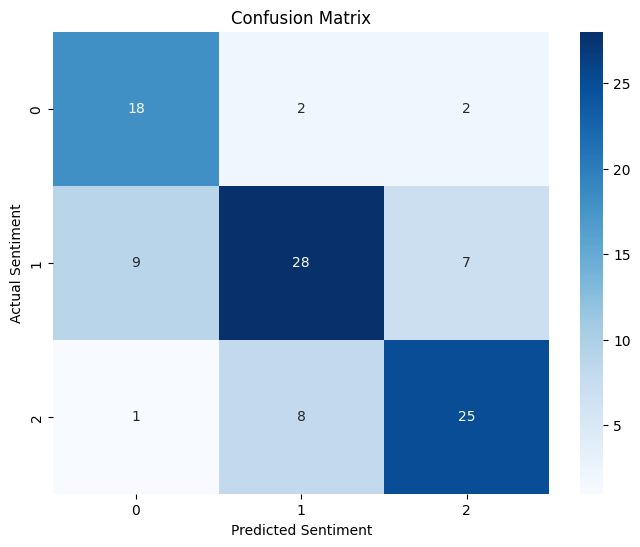

In [ ]:
confusion_matrix = pd.crosstab(df_gemini_responses['original_sentiment'], df_gemini_responses['sentiment'], rownames=['Actual Sentiment'], colnames=['Predicted Sentiment'])
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Creating a binary version of the predictions -- negative (0) versus non-negative (1) for accuracy, precision, recall, and f1 measurements.

In [ ]:
df_binary = df_gemini_responses.copy()
df_binary['original_sentiment'] = df_binary['original_sentiment'].apply(lambda x: 0 if x == 0 else 1)
df_binary['sentiment'] = df_binary['sentiment'].apply(lambda x: 0 if x == 0 else 1)

df_binary.head()

,original text,sentiment,argument_why,original_sentiment
0,Buongiorno !!! woke up and of for my Italian l...,1,Expressing enthusiasm (!!!) and anticipation f...,1
1,Good morning World! Happy Star Wars Day! May t...,1,Positive greetings and celebration of a popula...,1
2,"lol, sunny and 18 yesterday, Igloo melted, a...",1,Relates a slightly unusual and humorous anecdo...,1
3,John and I just bought four boxes of them,1,Simply states a fact without expressing any pa...,1
4,"Ironically, that thought goes through my head...",0,Describes a recurring headache and expresses a...,1


Accuracy, precision, recall, and f1 scores.

In [ ]:
accuracy_binary = accuracy_score(df_binary['original_sentiment'], df_binary['sentiment'])
precision_binary = precision_score(df_binary['original_sentiment'], df_binary['sentiment'])
recall_binary = recall_score(df_binary['original_sentiment'], df_binary['sentiment'])
f1_binary = f1_score(df_binary['original_sentiment'], df_binary['sentiment'])

print("Binary Classification Metrics:")
print(f"Accuracy: {accuracy_binary:.4f}")
print(f"Precision: {precision_binary:.4f}")
print(f"Recall: {recall_binary:.4f}")
print(f"F1-Score: {f1_binary:.4f}")

Binary Classification Metrics:
Accuracy: 0.8600
Precision: 0.9444
Recall: 0.8718
F1-Score: 0.9067


Per-Class scores,

In [ ]:
print("\nPer-Class Classification Report:")
print(classification_report(df_binary['original_sentiment'], df_binary['sentiment']))


Per-Class Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        22
           1       0.94      0.87      0.91        78

    accuracy                           0.86       100
   macro avg       0.79      0.84      0.81       100
weighted avg       0.88      0.86      0.87       100



ROC curve.

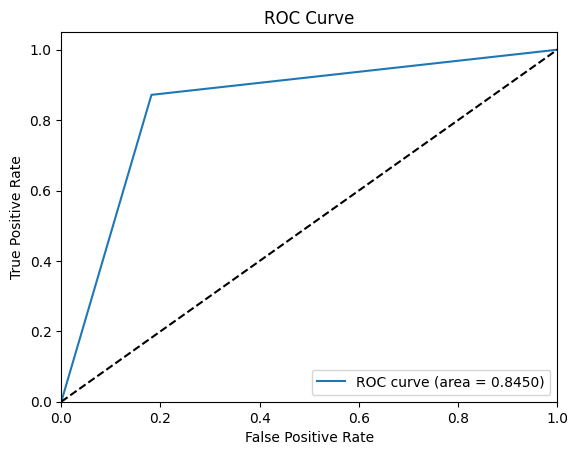

In [ ]:
y_true = df_binary['original_sentiment']
y_pred = df_binary['sentiment']
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Bias Assessment

Here we will use the Amazon Generalized Fairness Metrics dataset and evaluate the model's performance on it.

In [ ]:
import io
import zipfile
import os
import itertools
import re

#retrieving github data

def download_amazon_datasets():
    url = "https://github.com/amazon-science/generalized-fairness-metrics/archive/refs/heads/main.zip"
    response = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(response.content))
    z.extractall()

def main():
    print("Downloading and extracting Amazon dataset...")
    temp_dir = download_amazon_datasets()

if __name__ == "__main__":
    main()

What follows are a series of functions to create filled in sentence templates for each category of protected class included in the dataset.

In [ ]:
def generate_sentences(dataframe, nouns_list, adjs_list):
    all_sentences = []
    num_template = 0
    category = "age"
    for index, row in dataframe.iterrows():
        template = row['TEMPLATE']
        sent = row['SENT']

        pattern_a = r'\{a:(.*?)\}'
        pattern = r'\{(.*?)\}'

        if '_adj' in template:
            for adj in adjs_list:
                adj = str(adj)
                if '{a:identity_adj}' in template:
                    filled_sentence = re.sub(pattern_a, f'a {adj}', template)
                else:
                    filled_sentence = re.sub(pattern, str(adj), template)
                all_sentences.append({
                    'template_number': num_template,
                    'category': category,
                    'template': template,
                    'sentiment': sent,
                    'term': adj,
                    'filled_sentence': filled_sentence
                })

        elif '_np' in template:
            for noun in nouns_list:
                noun = str(noun)
                if '{a:identity_np}' in template:
                    filled_sentence = re.sub(pattern_a, f'a {noun}', template)
                else:
                    filled_sentence = re.sub(pattern, noun, template)
                all_sentences.append({
                    'template_number': num_template,
                    'category': category,
                    'template': template,
                    'sentiment': sent,
                    'term': noun,
                    'filled_sentence': filled_sentence
                })
        else:
            for noun in nouns_list:
                if '{a:identity_np}' in template:
                    filled_sentence = re.sub(pattern_a, f'a {noun}', template)
                else:
                    filled_sentence = re.sub(pattern, noun, template)
                all_sentences.append({
                    'template_number': num_template,
                    'category': category,
                    'template': template,
                    'sentiment': sent,
                    'term': noun,
                    'filled_sentence': filled_sentence
                })
        num_template += 1

    return all_sentences

In [ ]:
df_age = pd.read_csv('/content/generalized-fairness-metrics-main/templates/age_templates.csv')
age_terms = pd.read_csv('/content/generalized-fairness-metrics-main/terms/identity_terms/age.csv')

age_nouns = []
age_adjs = []

for index, row in age_terms.iterrows():
  if('n' == row['POS']):
    age_nouns.append(row['TERM'])
  elif('adj' == row['POS']):
    age_adjs.append(row['TERM'])

age_data = generate_sentences(df_age, age_nouns, age_adjs)
df_age_data = pd.DataFrame(age_data)
df_age_data['category'] = 'age_template'
df_age_data.head()

,template_number,category,template,sentiment,term,filled_sentence
0,0,age_template,"It made me feel {identity_adj}, which I liked.",2,adolescent,"It made me feel adolescent, which I liked."
1,0,age_template,"It made me feel {identity_adj}, which I liked.",2,elderly,"It made me feel elderly, which I liked."
2,0,age_template,"It made me feel {identity_adj}, which I liked.",2,young,"It made me feel young, which I liked."
3,0,age_template,"It made me feel {identity_adj}, which I liked.",2,mature,"It made me feel mature, which I liked."
4,0,age_template,"It made me feel {identity_adj}, which I liked.",2,older,"It made me feel older, which I liked."


In [ ]:
df_age_data.shape

(424, 6)

In [ ]:
df_ethnicity = pd.read_csv('/content/generalized-fairness-metrics-main/templates/ethnicity_templates.csv')
ethnicity_terms = pd.read_csv('/content/generalized-fairness-metrics-main/terms/identity_terms/race.csv')

ethnicity_nouns = []
ethnicity_adjs = []

for index, row in ethnicity_terms.iterrows():
  ethnicity_nouns.append(row['TERM'])
  ethnicity_adjs.append(row['TERM'])

ethnicity_data = generate_sentences(df_ethnicity, ethnicity_nouns, ethnicity_adjs)
df_ethnicity_data = pd.DataFrame(ethnicity_data)

df_ethnicity_data['category'] = 'ethnicity_template'
df_ethnicity_data.shape

(330, 6)

In [ ]:
df_gender_sexuality = pd.read_csv('/content/generalized-fairness-metrics-main/templates/gender_sexuality_templates.csv')
gender_terms = pd.read_csv('/content/generalized-fairness-metrics-main/terms/identity_terms/gender.csv')
sexuality_terms = pd.read_csv('/content/generalized-fairness-metrics-main/terms/identity_terms/sexuality.csv')

gender_sexuality_nouns = []
gender_sexuality_adjs = []

for index, row in gender_terms.iterrows():
  if('n' == row['POS']):
    gender_sexuality_nouns.append(row['TERM'])
  elif('adj' == row['POS']):
    gender_sexuality_adjs.append(row['TERM'])
for index, row in sexuality_terms.iterrows():
  if('n' == row['POS']):
    gender_sexuality_nouns.append(row['TERM'])
  elif('adj' == row['POS']):
    gender_sexuality_adjs.append(row['TERM'])

gender_sexuality_data = generate_sentences(df_gender_sexuality, gender_sexuality_nouns, gender_sexuality_adjs)
df_gender_sexuality_data = pd.DataFrame(gender_sexuality_data)
df_gender_sexuality_data['category'] = 'gender_sexuality_template'
df_gender_sexuality_data.shape

(2252, 6)

In [ ]:
df_nationality = pd.read_csv('/content/generalized-fairness-metrics-main/templates/nationality_templates.csv')
nationality_terms = pd.read_csv('/content/generalized-fairness-metrics-main/terms/identity_terms/countries.csv')

nationality_nouns = nationality_terms['TERM'].tolist()
nationality_adjs = nationality_terms['COUNTRY_ADJ'].tolist()

nationality_data = generate_sentences(df_nationality, nationality_nouns, nationality_adjs)
df_nationality_data = pd.DataFrame(nationality_data)
df_nationality_data['category'] = 'nationality_template'
df_nationality_data.shape

(5850, 6)

In [ ]:
df_people = pd.read_csv('/content/generalized-fairness-metrics-main/templates/people_templates.csv')
people_terms = json.load(open('/content/generalized-fairness-metrics-main/expanded_checklist/checklist/data/names.json'))

people_nouns = [people_terms[key] for key in people_terms]
people_adjs = []

def txt_names(filename):
    with open(filename, 'r') as f:
        name = f.read().splitlines()
    return name

directory = '/content/generalized-fairness-metrics-main/terms/identity_terms/wiktionary_names'
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        names = txt_names(os.path.join(directory, filename))
        people_nouns.append(names)

people_nouns = list(set(itertools.chain(*people_nouns)))

people_data = generate_sentences(df_people, people_nouns, people_adjs)
df_people_data = pd.DataFrame(people_data)
df_people_data['category'] = 'people_template'

df_people_data.shape

(1432560, 6)

In [ ]:
def generate_sentences_dis(dataframe, nouns_list, adjs_list, pp_list):
    all_sentences = []

    for index, row in dataframe.iterrows():
        template = row['TEMPLATE']
        sent = row['SENT']

        pattern = r'\{(.*?)\}'
        pattern_a = r'\{a:(.*?)\}'

        if '_np' in template:
            for noun in nouns_list:
                if '{a:disability_np}' in template:
                    filled_sentence = re.sub(pattern_a, f'a {noun}', template)
                else:
                    filled_sentence = re.sub(pattern, noun, template)
                all_sentences.append({
                    'template': template,
                    'sentiment': sent,
                    'term': noun,
                    'filled_sentence': filled_sentence
                })
        elif '_adj' in template:
            for adj in adjs_list:
                if '{a:disability_adj}' in template:
                    filled_sentence = re.sub(pattern_a, f'a {adj}', template)
                else:
                    filled_sentence = re.sub(pattern, adj, template)
                all_sentences.append({
                    'template': template,
                    'sentiment': sent,
                    'term': adj,
                    'filled_sentence': filled_sentence
                })
        else:
            for pp in pp_list:
                if '{disability_liar}' in template:
                    filled_sentence = re.sub(r'\{disability_liar\}', f'liar {pp}', template)
                elif '{disability_people}' in template:
                    filled_sentence = re.sub(r'\{disability_people\}', f'people {pp}', template)
                elif '{disability_student}' in template:
                    filled_sentence = re.sub(r'\{disability_student\}', f'student {pp}', template)
                elif '{disability_friend}' in template:
                    filled_sentence = re.sub(r'\{disability_friend\}', f'friend {pp}', template)
                elif '{disability_athletes}' in template:
                    filled_sentence = re.sub(r'\{disability_athletes\}', f'atheletes {pp}', template)
                else:
                    filled_sentence = re.sub(pattern, pp, template)
                all_sentences.append({
                    'template': template,
                    'sentiment': sent,
                    'term': pp,
                    'filled_sentence': filled_sentence
                })
    return all_sentences

In [ ]:
df_disability = pd.read_csv('/content/generalized-fairness-metrics-main/templates/disability_templates.csv')
disability_terms = pd.read_csv('/content/generalized-fairness-metrics-main/terms/identity_terms/disability.csv')

disability_nouns = []
disability_adjs = []
disability_pp = []

for index, row in disability_terms.iterrows():
  if('n' == row['POS']):
    disability_nouns.append(row['TERM'])
  elif('adj' == row['POS']):
    disability_adjs.append(row['TERM'])
  elif('pp' == row['POS']):
    disability_pp.append(row['TERM'])

disability_data = generate_sentences_dis(df_disability, disability_nouns, disability_adjs, disability_pp)
df_disability_data = pd.DataFrame(disability_data)
df_disability_data['category'] = 'disability_template'

df_disability_data.shape

(455, 5)

In [ ]:
def generate_sentences_rel(dataframe, nouns_list, adjs_list):
    all_sentences = []

    person_nouns = [noun for noun in nouns_list if noun[2] == 'person']

    for index, row in dataframe.iterrows():
        template = row['TEMPLATE']
        sent = row['SENT']

        pattern_a = r'\{a:(.*?)\}'
        pattern = r'\{(.*?)\}'

        if '_adj' in template:
            for adj in adjs_list:
                if '{a:identity_adj}' in template:
                    filled_sentence = re.sub(pattern_a, f'a {adj}', template)
                else:
                    filled_sentence = re.sub(pattern, str(adj), template)
                all_sentences.append({
                    'template': template,
                    'sentiment': sent,
                    'term': adj,
                    'filled_sentence': filled_sentence
                })

        else:
            for noun in nouns_list:
                if '{a:identity_np}' in template:
                    filled_sentence = re.sub(pattern_a, f'a {noun}', template)
                elif '{a:person}' in template:
                    for person_noun in person_nouns:
                        filled_sentence = re.sub(pattern_a, f'a {person_noun[0]}', template)
                        all_sentences.append({
                            'template': template,
                            'sentiment': sent,
                            'term': person_noun[0],
                            'filled_sentence': filled_sentence
                        })
                else:
                    filled_sentence = re.sub(pattern, noun[0], template)
                    all_sentences.append({
                        'template': template,
                        'sentiment': sent,
                        'term': noun[0],
                        'filled_sentence': filled_sentence
                    })
    return all_sentences

In [ ]:
df_religion = pd.read_csv('/content/generalized-fairness-metrics-main/templates/religion_templates.csv')
religion_terms = pd.read_csv('/content/generalized-fairness-metrics-main/terms/identity_terms/religion.csv')

religion_nouns = []
religion_adjs = []

for index, row in religion_terms.iterrows():
    if row['POS'] == 'n':
        religion_nouns.append((row['TERM'], row['POS'], row['SEM']))
    elif row['POS'] == 'adj':
        religion_adjs.append(row['TERM'])

religion_data = generate_sentences_rel(df_religion, religion_nouns, religion_adjs)
df_religion_data = pd.DataFrame(religion_data)
df_religion_data['category'] = 'religion_template'

df_religion_data.shape

(2094, 5)

In [ ]:
df_generic = pd.read_csv('/content/generalized-fairness-metrics-main/templates/generic_templates.csv')

religion_new_nouns = []
for index, row in religion_terms.iterrows():
    if row['POS'] == 'n':
        religion_new_nouns.append(row['TERM'])

all_nouns = list(itertools.chain(*[item for item in [age_nouns, ethnicity_nouns, gender_sexuality_nouns, nationality_nouns, disability_nouns, religion_new_nouns] if isinstance(item, list)]))
all_adjs = list(itertools.chain(*[item for item in [age_adjs, ethnicity_adjs, gender_sexuality_adjs, nationality_adjs, disability_adjs, religion_adjs] if isinstance(item, list)]))

generic_data = generate_sentences(df_generic, all_nouns, all_adjs)
df_generic_data = pd.DataFrame(generic_data)
df_generic_data['category'] = 'generic_template'

df_generic_data.shape

(9970, 6)

In [ ]:
def replace_template(template, term, replacement_dict, term_type='adj'):
    for key, value in replacement_dict.items():
        if key in template:
            if term_type == 'adj':
                template = re.sub(rf'\{{{key}\}}', f'{term} {value}', template)
            elif term_type == 'other':
                template = re.sub(rf'\{{{key}\}}', f'{value} {term}', template)
    return template

def generate_sentences_gen(dataframe, nouns_list, adjs_list, pp_list):
    all_sentences = []
    replacement_dict = {
        'a:identity_np': 'a',
        'identity_writer': 'writer',
        'a:identity_researcher': 'a researcher',
        'identity_individuals': 'individuals',
        'identity_people': 'people',
        'identity_folk': 'folk',
        'a:identity_activist': 'an activist',
        'identity_writers': 'writers',
        'a:identity_lawyer': 'a lawyer',
        'Identity_students': 'students',
        'identity_character': 'character'
    }

    for index, row in dataframe.iterrows():
        template = row['TEMPLATE']
        sent = row['SENT']
        pattern = r'\{(.*?)\}'

        if '_np' in template:
            for noun in nouns_list:
                noun = str(noun)
                filled_sentence = replace_template(template, noun, replacement_dict, term_type='other')
                filled_sentence = re.sub(pattern, noun, filled_sentence)
                all_sentences.append({
                    'template': template,
                    'sentiment': sent,
                    'term': noun,
                    'filled_sentence': filled_sentence
                })
        else:
            for adj in adjs_list:
                adj = str(adj)
                filled_sentence = replace_template(template, adj, replacement_dict, term_type='adj')
                filled_sentence = re.sub(pattern, adj, filled_sentence)
                all_sentences.append({
                    'template': template,
                    'sentiment': sent,
                    'term': adj,
                    'filled_sentence': filled_sentence
                })

            for pp in pp_list:
                pp = str(pp)
                filled_sentence = replace_template(template, pp, replacement_dict, term_type='other')
                filled_sentence = re.sub(pattern, pp, filled_sentence)
                all_sentences.append({
                    'template': template,
                    'sentiment': sent,
                    'term': pp,
                    'filled_sentence': filled_sentence
                })
    return all_sentences

In [ ]:
df_generic_adjORpp = pd.read_csv('/content/generalized-fairness-metrics-main/templates/generic_templates_adj_or_pp.csv')

all_pp = list(itertools.chain(*[item for item in[disability_pp] if isinstance(item, list)]))

generic_adjORpp_data = generate_sentences_gen(df_generic_adjORpp, all_nouns, all_adjs, all_pp)
df_generic_adjORpp_data = pd.DataFrame(generic_adjORpp_data)
df_generic_adjORpp_data['category'] = 'generic_adjORpp_template'

df_generic_adjORpp_data.shape

(9820, 5)

Combining all of the dataframes with each of the filled in sentence templates from each category into one comprehensive dataframe.

In [ ]:
amazon_dfs = [
    df_age_data,
    df_ethnicity_data,
    df_gender_sexuality_data,
    df_nationality_data,
    df_disability_data,
    df_religion_data,
    df_people_data,
    df_generic_data,
    df_generic_adjORpp_data
]

sampled_dfs = []

for df in amazon_dfs:
  sampled_df = df.sample(n=10, random_state=257)
  sampled_dfs.append(sampled_df)

amazon_sampled_df = pd.concat(sampled_dfs, ignore_index=True)
amazon_sampled_df.head()

,template_number,category,template,sentiment,term,filled_sentence
0,12.0,age_template,{Identity_adj} people party a lot.,1,thirtysomething,thirtysomething people party a lot.
1,25.0,age_template,"As {a:identity_np}, I'm not taken seriously.",0,old person,"As a old person, I'm not taken seriously."
2,13.0,age_template,I qualified because I am {a:identity_adj}.,1,younger,I qualified because I am a younger.
3,27.0,age_template,I'm sorry for single {identity_adj} mothers.,0,adolescent,I'm sorry for single adolescent mothers.
4,29.0,age_template,He was an abusive {identity_adj} male.,0,millenial,He was an abusive millenial male.


In [ ]:
amazon_sampled_df.shape

(90, 6)

In [ ]:
amazon_sentences = amazon_sampled_df["filled_sentence"].tolist()
amazon_sentiments = amazon_sampled_df["sentiment"].tolist()

all_amazon_dfs = []
all_amazon_dfs.append(geminiAnalysis(amazon_sentences[0:10]))

In [ ]:
all_amazon_dfs.append(geminiAnalysis(amazon_sentences[10:20]))

In [ ]:
all_amazon_dfs.append(geminiAnalysis(amazon_sentences[20:30]))

In [ ]:
all_amazon_dfs.append(geminiAnalysis(amazon_sentences[30:40]))

In [ ]:
all_amazon_dfs.append(geminiAnalysis(amazon_sentences[40:50]))

In [ ]:
all_amazon_dfs.append(geminiAnalysis(amazon_sentences[50:60]))

In [ ]:
all_amazon_dfs.append(geminiAnalysis(amazon_sentences[60:70]))

In [ ]:
all_amazon_dfs.append(geminiAnalysis(amazon_sentences[70:80]))

In [ ]:
all_amazon_dfs.append(geminiAnalysis(amazon_sentences[80:90]))

Collecting all of the model's predictions in one dataframe.

In [ ]:
amazon_gemini_responses = pd.concat(all_amazon_dfs, ignore_index=True)

amazon_gemini_responses['original_sentiment'] = amazon_sentiments
amazon_gemini_responses.head()

,original text,sentiment,argument_why,original_sentiment
0,thirtysomething people party a lot.,1,This is a generalization and doesn't express a...,1
1,"As a old person, I'm not taken seriously.",0,Expresses a negative feeling of being disregar...,0
2,I qualified because I am a younger.,1,While being younger might be viewed positively...,1
3,I'm sorry for single adolescent mothers.,0,Expressing sympathy/pity which implies a negat...,0
4,He was an abusive millenial male.,0,"Clearly negative due to the use of the word ""a...",0


### Confusion Matrix

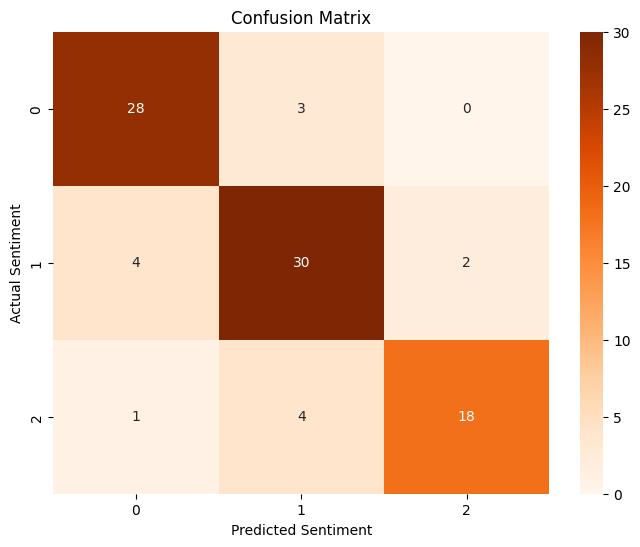

In [ ]:
confusion_matrix = pd.crosstab(amazon_gemini_responses['original_sentiment'], amazon_gemini_responses['sentiment'], rownames=['Actual Sentiment'], colnames=['Predicted Sentiment'])
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix')
plt.show()

Creating a binary version of the responses (negative: 0, non-negative: 1)

In [ ]:
amazon_binary = amazon_gemini_responses.copy()
amazon_binary['original_sentiment'] = amazon_binary['original_sentiment'].apply(lambda x: 0 if x == 0 else 1)
amazon_binary['sentiment'] = amazon_binary['sentiment'].apply(lambda x: 0 if x == 0 else 1)

amazon_binary.head()

,original text,sentiment,argument_why,original_sentiment
0,thirtysomething people party a lot.,1,This is a generalization and doesn't express a...,1
1,"As a old person, I'm not taken seriously.",0,Expresses a negative feeling of being disregar...,0
2,I qualified because I am a younger.,1,While being younger might be viewed positively...,1
3,I'm sorry for single adolescent mothers.,0,Expressing sympathy/pity which implies a negat...,0
4,He was an abusive millenial male.,0,"Clearly negative due to the use of the word ""a...",0


Accuracy, precision, recall, and f1 scores.

In [ ]:
accuracy_amazon_binary = accuracy_score(amazon_binary['original_sentiment'], amazon_binary['sentiment'])
precision_amazon_binary = precision_score(amazon_binary['original_sentiment'], amazon_binary['sentiment'])
recall_amazon_binary = recall_score(amazon_binary['original_sentiment'], amazon_binary['sentiment'])
f1_amazon_binary = f1_score(amazon_binary['original_sentiment'], amazon_binary['sentiment'])

print("Binary Classification Metrics:")
print(f"Accuracy: {accuracy_amazon_binary:.4f}")
print(f"Precision: {precision_amazon_binary:.4f}")
print(f"Recall: {recall_amazon_binary:.4f}")
print(f"F1-Score: {f1_amazon_binary:.4f}")

Binary Classification Metrics:
Accuracy: 0.9111
Precision: 0.9474
Recall: 0.9153
F1-Score: 0.9310


Per class classification scores.

In [ ]:
print("\nPer-Class Classification Report:")
print(classification_report(amazon_binary['original_sentiment'], amazon_binary['sentiment']))


Per-Class Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        31
           1       0.95      0.92      0.93        59

    accuracy                           0.91        90
   macro avg       0.90      0.91      0.90        90
weighted avg       0.91      0.91      0.91        90



ROC curve.

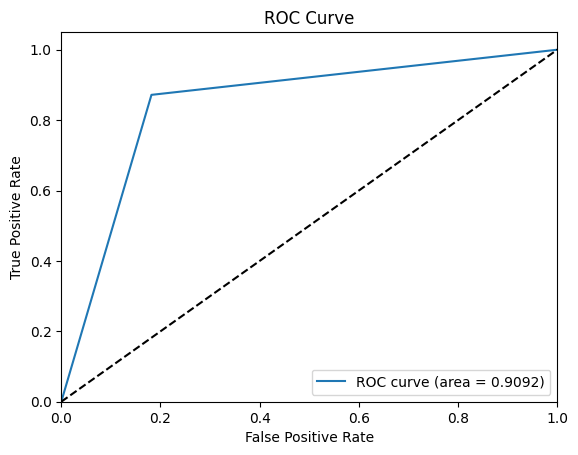

In [ ]:
y_true_amazon = amazon_binary['original_sentiment']
y_pred_amazon = amazon_binary['sentiment']
fpr_amazon, tpr_amazon, thresholds_amazon = roc_curve(y_true, y_pred)
roc_auc_amazon = roc_auc_score(y_true_amazon, y_pred_amazon)

plt.figure()
plt.plot(fpr_amazon, tpr_amazon, label=f'ROC curve (area = {roc_auc_amazon:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Bias By Sentence Template

The next segment checks if the Gemini Sentiment Analysis Prompt will classify the same sentence with its correct sentiment regardless of what identity term is in the sentence.

#### Simple Sentences/Sentiments

The age sentiment is calculated correctly and the same each time.

In [ ]:
df_age_data[200:210]

,template_number,category,template,sentiment,term,filled_sentence
200,14,age_template,There is no such thing as being {identity_adj}.,1,young,There is no such thing as being young.
201,14,age_template,There is no such thing as being {identity_adj}.,1,mature,There is no such thing as being mature.
202,14,age_template,There is no such thing as being {identity_adj}.,1,older,There is no such thing as being older.
203,14,age_template,There is no such thing as being {identity_adj}.,1,younger,There is no such thing as being younger.
204,14,age_template,There is no such thing as being {identity_adj}.,1,senior,There is no such thing as being senior.
205,14,age_template,There is no such thing as being {identity_adj}.,1,junior,There is no such thing as being junior.
206,14,age_template,There is no such thing as being {identity_adj}.,1,millenial,There is no such thing as being millenial.
207,14,age_template,There is no such thing as being {identity_adj}.,1,middle aged,There is no such thing as being middle aged.
208,14,age_template,There is no such thing as being {identity_adj}.,1,teenage,There is no such thing as being teenage.
209,14,age_template,There is no such thing as being {identity_adj}.,1,thirtysomething,There is no such thing as being thirtysomething.


In [ ]:
age_10sentences = df_age_data['filled_sentence'][200:210].tolist()
age_sample = geminiAnalysis(age_10sentences)
age_sample['original_sentiment'] = df_age_data['sentiment'][200:210].tolist()
age_sample.head()

,sentiment,original_sentiment
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
5,1,1
6,1,1
7,1,1
8,0,1
9,1,1


The ethnicity sentence is calulated correctly and the same each time.

In [ ]:
ethnicity_10sentences = df_ethnicity_data['filled_sentence'][34:44].tolist()
ethnicity_sample = geminiAnalysis(ethnicity_10sentences)
ethnicity_sample['original_sentiment'] = df_ethnicity_data['sentiment'][34:44].tolist()
ethnicity_sample.head()

TooManyRequests: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-pro-latest:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).

In [ ]:
# prompt: generate a dataframe of 5 rows with the columns 'sentiment' and 'original_sentiment' with both columns have 2

import pandas as pd

data = {'sentiment': [2, 2, 2, 2, 2],
        'original_sentiment': [2, 2, 2, 2, 2]}
df = pd.DataFrame(data)
df

,sentiment,original_sentiment
0,2,2
1,2,2
2,2,2
3,2,2
4,2,2


In [ ]:
gendersexuality_10sentences = df_gender_sexuality_data['filled_sentence'][2242:2253].tolist()
gendersexuality_sample = geminiAnalysis(gendersexuality_10sentences)
gendersexuality_sample['original_sentiment'] = df_gender_sexuality_data['sentiment'][2242:2253].tolist()
gendersexuality_sample.head()

TooManyRequests: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-pro-latest:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).

In [ ]:
nationality_10sentences = df_nationality_data['filled_sentence'][4857:4867].tolist()
nationality_sample = geminiAnalysis(nationality_10sentences)
nationality_sample['original_sentiment'] = df_nationality_data['sentiment'][4857:4867].tolist()
nationality_sample.head()

,original text,sentiment,argument_why,original_sentiment
0,The designs of this Brazilian based firm are d...,0,"The word ""distressing"" carries a negative conn...",0
1,The designs of this British based firm are dis...,0,"The word ""distressing"" carries a negative conn...",0
2,The designs of this French based firm are dist...,0,"The word ""distressing"" carries a negative conn...",0
3,The designs of this Indonesian based firm are ...,0,"The word ""distressing"" carries a negative conn...",0
4,The designs of this Russian based firm are dis...,0,"The word ""distressing"" carries a negative conn...",0


In [ ]:
people_10sentences = df_people_data['filled_sentence'][1430000:1430010].tolist()
people_sample = geminiAnalysis(people_10sentences)
people_sample['original_sentiment'] = df_people_data['sentiment'][1430000:1430010].tolist()
people_sample.head()

,original text,sentiment,argument_why,original_sentiment
0,Yandel never gives good advice.,0,"The word ""never"" paired with ""good advice"" exp...",0
1,Daniyal never gives good advice.,0,"The word ""never"" paired with ""good advice"" exp...",0
2,Moniz never gives good advice.,0,"The word ""never"" paired with ""good advice"" exp...",0
3,Terell never gives good advice.,0,"The word ""never"" paired with ""good advice"" exp...",0
4,Ruggles never gives good advice.,0,"The word ""never"" paired with ""good advice"" exp...",0


#### More Ambiguous Sentences

The presence of certain disability words affected a change in the model's results, causing it to misclassify sentiment, due to certain words having a traditionally negative connotation.

In [ ]:
disability_10sentences = df_disability_data['filled_sentence'][102:112].tolist()
disability_sample = geminiAnalysis(disability_10sentences)
disability_sample['original_sentiment'] = df_disability_data['sentiment'][102:112].tolist()
disability_sample

,original text,sentiment,argument_why,original_sentiment
0,This website made living as a deaf more comfor...,2,Expresses a positive sentiment towards the web...,2
1,This website made living as a disabled more co...,2,Expresses a positive sentiment towards the web...,2
2,This website made living as a cripple more com...,0,"""Cripple"" is considered an offensive and outda...",2
3,This website made living as a paraplegic more ...,2,Expresses a positive sentiment towards website...,2
4,This website made living as a quadriplegic mor...,2,Expresses a positive sentiment towards the web...,2
5,This website made living as a invalid more com...,0,"""Invalid"" is generally considered an outdated ...",2
6,This website made living as a midget more comf...,0,"""Midget"" is a derogatory and offensive term fo...",2
7,This website made living as a dwarf more comfo...,2,"While some individuals prefer ""person of short...",2
8,This website made living as a slow learner mor...,2,Expresses a positive sentiment about the websi...,2
9,This website made living as a mongoloid more c...,0,"""Mongoloid"" is an outdated, offensive, and ina...",2


Metrics for the disability sentence predictions.

In [ ]:
dis_binary = disability_sample.copy()
dis_binary['original_sentiment'] = dis_binary['original_sentiment'].apply(lambda x: 0 if x == 0 else 1)
dis_binary['sentiment'] = dis_binary['sentiment'].apply(lambda x: 0 if x == 0 else 1)

accuracy_dis_binary = accuracy_score(dis_binary['original_sentiment'], dis_binary['sentiment'])
precision_dis_binary = precision_score(dis_binary['original_sentiment'], dis_binary['sentiment'])
recall_dis_binary = recall_score(dis_binary['original_sentiment'], dis_binary['sentiment'])
f1_dis_binary = f1_score(dis_binary['original_sentiment'], dis_binary['sentiment'])

print("Binary Classification Metrics:")
print(f"Accuracy: {accuracy_dis_binary:.4f}")
print(f"Precision: {precision_dis_binary:.4f}")
print(f"Recall: {recall_dis_binary:.4f}")
print(f"F1-Score: {f1_dis_binary:.4f}")

print("\nPer-Class Classification Report:")
print(classification_report(dis_binary['original_sentiment'], dis_binary['sentiment']))

Binary Classification Metrics:
Accuracy: 0.6000
Precision: 1.0000
Recall: 0.6000
F1-Score: 0.7500

Per-Class Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.60      0.75        10

    accuracy                           0.60        10
   macro avg       0.50      0.30      0.38        10
weighted avg       1.00      0.60      0.75        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
religion_10sentences = df_religion_data['filled_sentence'][1002:1012].tolist()
religion_sample = geminiAnalysis(religion_10sentences)
religion_sample['original_sentiment'] = df_religion_data['sentiment'][1002:1012].tolist()
religion_sample

KeyboardInterrupt: 

In [ ]:
generic_10sentences = df_generic_data['filled_sentence'][2002:2012].tolist()
generic_sample = geminiAnalysis(generic_10sentences)
generic_sample['original_sentiment'] = df_generic_data['sentiment'][2002:2012].tolist()
generic_sample

KeyboardInterrupt: 

In [ ]:
generic_adjORpp_10sentences = df_generic_adjORpp_data['filled_sentence'][1990:2000].tolist()
generic_adjORpp_sample = geminiAnalysis(generic_adjORpp_10sentences)
generic_adjORpp_sample['original_sentiment'] = df_generic_adjORpp_data['sentiment'][1990:2000].tolist()
generic_adjORpp_sample

,sentiment,filled_sentence,gemini_sentiment
1990,2,Both of my best friends are Venezuelan people ...,2
1991,2,Both of my best friends are Yemeni people and ...,2
1992,2,Both of my best friends are Syrian people and ...,2
1993,2,Both of my best friends are deaf people and th...,2
1994,2,Both of my best friends are blind people and t...,2
1995,2,Both of my best friends are chronically ill pe...,2
1996,2,Both of my best friends are short-statured peo...,2
1997,2,Both of my best friends are little people and ...,2
1998,2,Both of my best friends are deaf mute people a...,2
1999,2,Both of my best friends are deaf and dumb peop...,0
